In [1]:
from sklearn.preprocessing import StandardScaler
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage.transform import resize
import pandas as pd
from matplotlib.image import imread
from skimage.io import imread_collection
from PIL import Image
import seaborn as sns
from sklearn import decomposition, preprocessing, svm
import sklearn.metrics as metrics #confusion_matrix, accuracy_score
from time import sleep 
from tqdm.notebook import tqdm
import os
sns.set()

/var/folders/d5/0nkl4bqj2712httng60lv1cr0000gn/T/ipykernel_61415/3846356963.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#Dataset that should go with Alzheimer label
very_mild = glob(r'/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/Dataset/Very_Mild_Demented/*')
mild = glob(r'/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/Dataset/Mild_Demented/*')
moderate = glob(r'/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/Dataset/Moderate_Demented/*')

#Dataset without Alzheimer
non = glob(r'/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/Dataset/Non_Demented/*')

/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/Dataset/Non_Demented/non_1815.jpg
One of the data in Non Alzheimer Folder
Image shape:(128, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

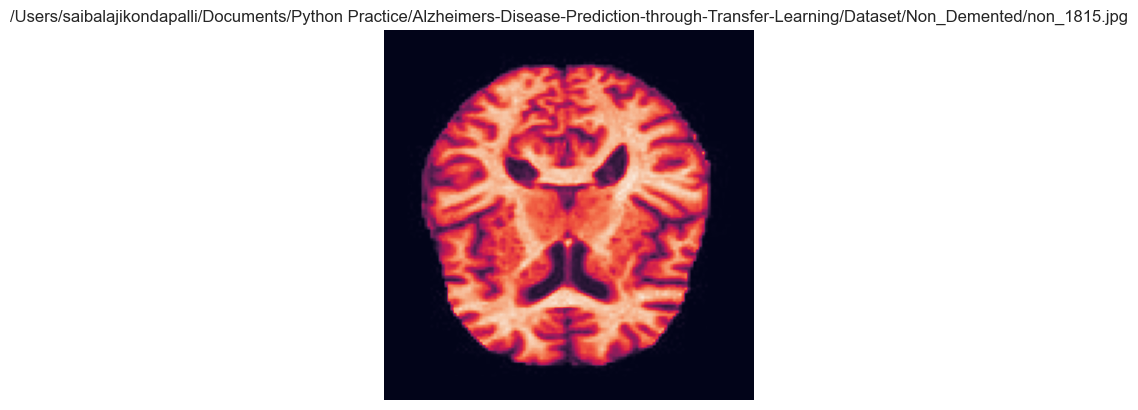

In [4]:
print(non[1])
def display_image(directory):
    img = mpimg.imread(directory)
    plt.imshow(img)
    plt.title(directory)
    plt.axis('off')
    print(f'Image shape:{img.shape}')
    return img

print('One of the data in Non Alzheimer Folder')
display_image(non[1])

Alzheimer Patient's Brain
Image shape:(128, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

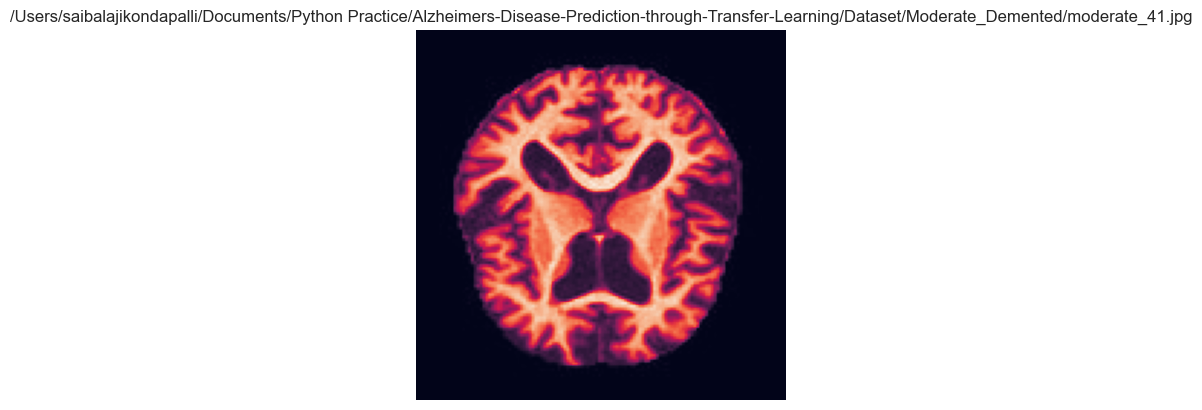

In [5]:
print('Alzheimer Patient\'s Brain')
display_image(moderate[1])

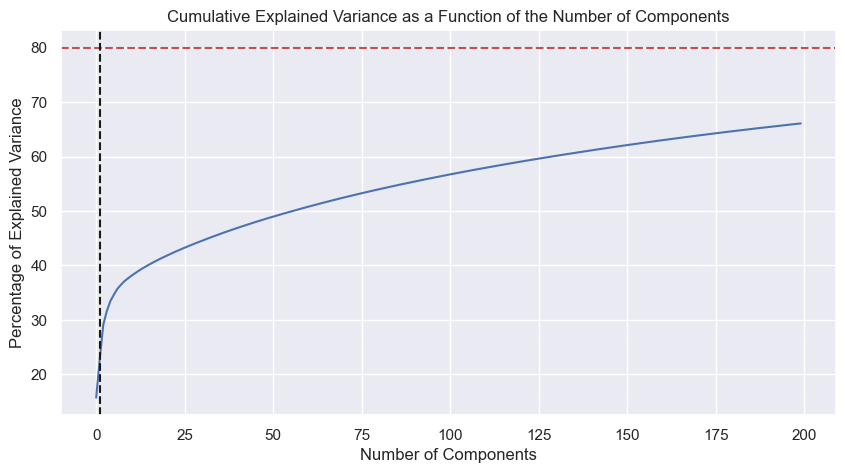

Number of components explaining at least 80% variance: 1
Projected data shape: (5120, 200)


In [6]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Image processing function
def process_image(image_path):
    image = mpimg.imread(image_path)
    image = image / 255.0  # Normalizing the image
    image = resize(image, (128, 128, 3))  # Resizing the image
    image_flattened = image.reshape((128, 384))  # Flattening the image
    return image_flattened

# Feature extraction
non_demented_features = [process_image(path) for path in non]
very_mild_demented_features = [process_image(path) for path in very_mild]
mild_demented_features = [process_image(path) for path in mild]
moderate_demented_features = [process_image(path) for path in moderate]

# Combining all Alzheimer's data
alzheimers_features = very_mild_demented_features + mild_demented_features + moderate_demented_features

# Data concatenation and preparation
all_features = np.array(non_demented_features + alzheimers_features)
all_features_reshaped = all_features.reshape(all_features.shape[0], -1)

# Standardizing features
scaler = StandardScaler()
all_features_standard = scaler.fit_transform(all_features_reshaped)

# Labels for the dataset
labels = [0] * len(non_demented_features) + [1] * len(alzheimers_features)

# Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(all_features_standard, labels, test_size=0.2, random_state=42)

# Applying Principal Component Analysis (PCA)
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train)

# Cumulative variance plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
significant_component = np.argmax(cumulative_variance >= 80) + 1

# Plotting the scree plot
plt.figure(figsize=[10,5])
plt.plot(cumulative_variance)
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Number of Components')
plt.axhline(y=80, color='r', linestyle='--')
plt.axvline(x=significant_component, color='k', linestyle='--')
plt.show()

print(f"Number of components explaining at least 80% variance: {significant_component}")
print("Projected data shape:", X_train_pca.shape)

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Initialize LDA with one component
lda_model = LDA(n_components=1)

# Fit the model on training data and transform
X_train_lda = lda_model.fit_transform(X_train, y_train)

# Transform testing data using the already-fitted model
X_test_lda = lda_model.transform(X_test)

# Calculate accuracy on testing data
test_accuracy = lda_model.score(X_test, y_test) * 100
print(f"{test_accuracy:.2f}% accuracy (testing data)")

# Calculate accuracy on training data
train_accuracy = lda_model.score(X_train, y_train) * 100
print(f"{train_accuracy:.2f}% accuracy (training data)")


89.53% accuracy (testing data)
100.00% accuracy (training data)


In [43]:
# Initialize lists to store resized images and their labels
resized_images = []
image_labels = []

# Target dimensions for the images
target_width = 128
target_height = 128
new_size = (target_width, target_height)

# Function to resize images in a given directory and label them
def resize_and_label_images(image_paths, label):
    for file_path in image_paths:
        # Open and resize the image
        img = Image.open(file_path).resize(new_size)
        
        # Convert the image to a numpy array
        img_array = np.array(img)
        
        # Calculate the new shape for flattening the array
        shape_new = target_width * target_height
        
        # Reshape the image array to 1D (flattened)
        img_wide = img_array.reshape(1, shape_new)
        
        # Append the processed image to the list (taking the first row of img_wide)
        resized_images.append(img_wide[0])
        
        # Append the label
        image_labels.append(label)

# Paths to the different sets of images
ALZ = very_mild + mild + moderate  # Combine paths from all stages

# Process the images and assign labels
resize_and_label_images(non, 0)  # Label 0 for non-demented
resize_and_label_images(ALZ, 1)     # Label 1 for any Alzheimer's stage


In [11]:
print(len(non))
print(len(ALZ)) #data are well transformed. Let's conduct SVM
print(len(resized_images))
print(resized_images[1])

#split the data to test and training

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(resized_images, image_labels, test_size = 0.2)

3200
3200
6400
[0 0 0 ... 0 0 0]


In [12]:
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Train SVM model
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(train_x, train_y)

# Store predictions and ground truth for training data
train_predictions = svm_classifier.predict(train_x)
train_actual = train_y

# Assess the performance of the SVM with a linear kernel on Training data
print('Training Performance:')
print('Accuracy :', accuracy_score(train_actual, train_predictions))
print('Precision:', precision_score(train_actual, train_predictions))
print('Recall   :', recall_score(train_actual, train_predictions))
print('F1 Score :', f1_score(train_actual, train_predictions))
print('Confusion Matrix:\n', confusion_matrix(train_actual, train_predictions))
print()

# Use the SVM model to predict Test data
test_predictions = svm_classifier.predict(test_x)
test_actual = test_y

# Assess the performance of the SVM with a linear kernel on Testing data
print('Testing Performance:')
print('Accuracy :', accuracy_score(test_actual, test_predictions))
print('Precision:', precision_score(test_actual, test_predictions))
print('Recall   :', recall_score(test_actual, test_predictions))
print('F1 Score :', f1_score(test_actual, test_predictions))
print('Confusion Matrix:\n', confusion_matrix(test_actual, test_predictions))


Training Performance:
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0
Confusion Matrix:
 [[2539    0]
 [   0 2581]]

Testing Performance:
Accuracy : 0.98828125
Precision: 0.9870967741935484
Recall   : 0.9886914378029079
F1 Score : 0.9878934624697336
Confusion Matrix:
 [[653   8]
 [  7 612]]


In [10]:
# Train an SVM using a polynomial kernel with degree 2
poly_svm_classifier = svm.SVC(kernel='poly', degree=2)
poly_svm_classifier.fit(train_x, train_y)

# Store predictions and ground truth for training data
train_predictions_poly = poly_svm_classifier.predict(train_x)
train_actual_poly = train_y

# Assess the performance of the SVM with a polynomial kernel on Training data
print('Training Performance (Polynomial Kernel):')
print('Accuracy  :', accuracy_score(train_actual_poly, train_predictions_poly))
print('Precision :', precision_score(train_actual_poly, train_predictions_poly))
print('Recall    :', recall_score(train_actual_poly, train_predictions_poly))
print('F1 Score  :', f1_score(train_actual_poly, train_predictions_poly))
print('Confusion Matrix:\n', confusion_matrix(train_actual_poly, train_predictions_poly))
print()

# Use the SVM model to predict Test data
test_predictions_poly = poly_svm_classifier.predict(test_x)
test_actual_poly = test_y

# Assess the performance of the SVM with a polynomial kernel on Testing data
print('Testing Performance (Polynomial Kernel):')
print('Accuracy  :', accuracy_score(test_actual_poly, test_predictions_poly))
print('Precision :', precision_score(test_actual_poly, test_predictions_poly))
print('Recall    :', recall_score(test_actual_poly, test_predictions_poly))
print('F1 Score  :', f1_score(test_actual_poly, test_predictions_poly))
print('Confusion Matrix:\n', confusion_matrix(test_actual_poly, test_predictions_poly))


Accuracy :  0.8958984375
Precision :  0.88871834228703
Recall :  0.9050410316529894
f1 :  0.8968054211035817
Confusion matrix : [[2271  290]
 [ 243 2316]]
Accuracy :  0.859375
Precision :  0.8424962852897474
Recall :  0.8845553822152886
f1 :  0.863013698630137
Confusion matrix : [[533 106]
 [ 74 567]]


In [13]:
# Train an SVM with the RBF kernel
rbf_svm_classifier = svm.SVC(kernel='rbf')
rbf_svm_classifier.fit(train_x, train_y)

# Store predictions and ground truth for training data
train_predictions_rbf = rbf_svm_classifier.predict(train_x)
train_actual_rbf = train_y

# Assess the performance of the SVM with the RBF kernel on Training data
print('Training Performance (RBF Kernel):')
print('Accuracy  :', accuracy_score(train_actual_rbf, train_predictions_rbf))
print('Precision :', precision_score(train_actual_rbf, train_predictions_rbf))
print('Recall    :', recall_score(train_actual_rbf, train_predictions_rbf))
print('F1 Score  :', f1_score(train_actual_rbf, train_predictions_rbf))
print('Confusion Matrix:\n', confusion_matrix(train_actual_rbf, train_predictions_rbf))
print()

# Use the SVM model to predict Test data
test_predictions_rbf = rbf_svm_classifier.predict(test_x)
test_actual_rbf = test_y

# Assess the performance of the SVM with the RBF kernel on Testing data
print('Testing Performance (RBF Kernel):')
print('Accuracy  :', accuracy_score(test_actual_rbf, test_predictions_rbf))
print('Precision :', precision_score(test_actual_rbf, test_predictions_rbf))
print('Recall    :', recall_score(test_actual_rbf, test_predictions_rbf))
print('F1 Score  :', f1_score(test_actual_rbf, test_predictions_rbf))
print('Confusion Matrix:\n', confusion_matrix(test_actual_rbf, test_predictions_rbf))


Training Performance (RBF Kernel):
Accuracy  : 0.8625
Precision : 0.8459270180611869
Recall    : 0.8891902363425029
F1 Score  : 0.8670192670948244
Confusion Matrix:
 [[2121  418]
 [ 286 2295]]

Testing Performance (RBF Kernel):
Accuracy  : 0.821875
Precision : 0.7896296296296297
Recall    : 0.8610662358642972
F1 Score  : 0.8238021638330757
Confusion Matrix:
 [[519 142]
 [ 86 533]]


In [15]:
# Function to preprocess and extract features from an image
def extract_feature(dir_path):
    img = mpimg.imread(dir_path)
    img = img / 255.0  # normalize pixel values
    img = resize(img, (128, 128, 3))  # convert all images to (128x128x3)
    img_flattened = img.reshape(-1)  # flatten the image to 1D array
    return img_flattened

# Load and process images from each category
non_ALZ = [extract_feature(filename) for filename in non]
vmild_ALZ = [extract_feature(filename) for filename in very_mild]
mild_ALZ = [extract_feature(filename) for filename in mild]
moderate_ALZ = [extract_feature(filename) for filename in moderate]
ALZ = vmild_ALZ + mild_ALZ + moderate_ALZ

# Combine all processed data
all_data = np.array(non_ALZ + ALZ)  # This will be a 2D array now

# Standardize the data to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_data)  # This should work without error now

# Split the standardized data into training and testing sets
labels = [0] * len(non_ALZ) + [1] * len(ALZ)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

# Function to convert a flattened grayscale image back to RGB (128x128x3)
def to_rgb(img_flat):
    img_reshaped = img_flat.reshape((128, 128, 3))  # reshape the flat array to 3D (RGB channels retained)
    img_rgb = (img_reshaped * 255).astype(np.uint8)  # scale back to 0-255 and convert to uint8
    return img_rgb

# Convert X_train and X_test data to RGB images
rgb_array_train = np.array([to_rgb(img) for img in X_train])
rgb_array_test = np.array([to_rgb(img) for img in X_test])

print(rgb_array_train.shape)  # Should print (n_samples_train, 128, 128, 3)
print(rgb_array_test.shape)   # Should print (n_samples_test, 128, 128, 3)


(5120, 128, 128, 3)
(1280, 128, 128, 3)


In [16]:
# Convert X_test data to RGB images using the to_rgb function defined previously
rgb_list_test = [to_rgb(img) for img in X_test]

# Stack all RGB images into a single numpy array
rgb_array_test = np.array(rgb_list_test)

print(rgb_array_test.shape)  # Should print (n_samples, 128, 128, 3) where n_samples is the length of X_test


(1280, 128, 128, 3)


In [42]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os

# Initialize lists to store the resized images and their corresponding labels
resized_images = []
image_labels = []

# Define the new size for the images
new_size = (128, 128)

# Function to resize images and append them to the respective lists
def resize_and_label_images(image_paths, label):
    for file_path in image_paths:
        img = Image.open(file_path)
        img_resized = img.resize(new_size)
        img_array = np.array(img_resized).flatten()  # Flatten the array
        resized_images.append(img_array)
        image_labels.append(label)

# Directories containing the images for each category
# Assuming 'non', 'very_mild', 'mild', 'moderate' are lists of file paths for the images
resize_and_label_images(non, 0)  # Non-demented
resize_and_label_images(very_mild, 1)  # Very mild demented
resize_and_label_images(mild, 2)  # Mild demented
resize_and_label_images(moderate, 3)  # Moderate demented

# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(resized_images, image_labels, test_size=0.2, random_state=42)

# Train SVM model with a linear kernel
linear_svm = svm.SVC(kernel='linear')
linear_svm.fit(train_x, train_y)

# Make predictions on the training data and assess performance
train_predictions = linear_svm.predict(train_x)
train_accuracy = accuracy_score(train_y, train_predictions)
print('Training Accuracy:', train_accuracy)

# Make predictions on the testing data and assess performance
test_predictions = linear_svm.predict(test_x)
test_accuracy = accuracy_score(test_y, test_predictions)
print('Testing Accuracy:', test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 0.98671875


In [40]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

# Load VGG16 model, pre-trained on ImageNet data and without the fully-connected top layers
vgg16_base = VGG16(weights='/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                   input_shape=(128, 128, 3), include_top=False)

# Freeze the layers of the VGG16 base model
for layer in vgg16_base.layers:
    layer.trainable = False

# Create the final model and add the VGG16 base model
model = Sequential()
model.add(vgg16_base)
model.add(Flatten(name='flatten'))

# Add a fully connected layer with 2 outputs and softmax activation
model.add(Dense(2, activation='softmax', name='predictions'))

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model on the training data
history_train = model.fit(rgb_array_train, np.array(y_train), batch_size=7, epochs=30, verbose=1, validation_split=0.2)

# Evaluate the model on the test data
history_test = model.evaluate(rgb_array_test, np.array(y_test), batch_size=7, verbose=1)


Epoch 1/30
586/586 [==============================] - 147s 250ms/step - loss: 3.9856 - accuracy: 0.5701 - val_loss: 11.8529 - val_accuracy: 0.4902
Epoch 2/30
586/586 [==============================] - 153s 261ms/step - loss: 4.2482 - accuracy: 0.6177 - val_loss: 4.4210 - val_accuracy: 0.5537
Epoch 3/30
586/586 [==============================] - 147s 251ms/step - loss: 4.1157 - accuracy: 0.6445 - val_loss: 3.3769 - val_accuracy: 0.6006
Epoch 4/30
586/586 [==============================] - 144s 245ms/step - loss: 3.0005 - accuracy: 0.6809 - val_loss: 2.8451 - val_accuracy: 0.6035
Epoch 5/30
586/586 [==============================] - 143s 245ms/step - loss: 2.7470 - accuracy: 0.6819 - val_loss: 3.7438 - val_accuracy: 0.6123
Epoch 6/30
586/586 [==============================] - 145s 248ms/step - loss: 3.3048 - accuracy: 0.6743 - val_loss: 7.4828 - val_accuracy: 0.5205
Epoch 7/30
586/586 [==============================] - 143s 245ms/step - loss: 3.6646 - accuracy: 0.6694 - val_loss: 4.5131 

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4054695 (15.47 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 4049571 (15.45 MB)
___________________

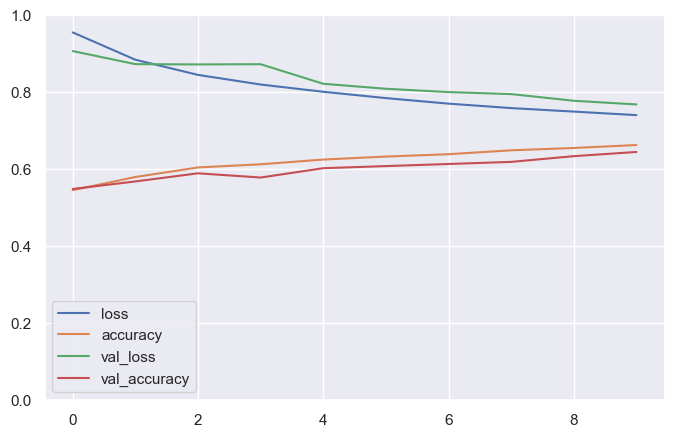

40/40 [==============================] - 4s 89ms/step - loss: 0.7672 - accuracy: 0.6438
Test accuracy: 64.38%


In [20]:
import os
import tensorflow as tf
import pandas as pd

# Path to the downloaded weights file
weights_path = '/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/efficientnetb0_notop.h5'

# Check if the weights file exists
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Weights file not found at {weights_path}")

# Load the dataset
data_dir = '/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/Dataset'
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'],
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    color_mode='rgb',  # Change to 'rgb' as EfficientNet requires three channels
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented'],
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    color_mode='rgb',  # Change to 'rgb' as EfficientNet requires three channels
)

# Model setup
EffNet = tf.keras.applications.EfficientNetB0(include_top=False, weights=weights_path, input_shape=(128, 128, 3))
EffNet.trainable = False  # Set to False to freeze layers and reuse pre-trained weights

# Functional API setup
inputs = tf.keras.layers.Input(shape=(128, 128, 3), name='input_layer')
x = EffNet(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
learning_rate = 0.001
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Summary of the model
model.summary()

# Training the Model
history = model.fit(train_data, validation_data=test_data, epochs=10, verbose=1)

# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.show()

# Evaluate the performance on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy*100:.2f}%")


In [22]:
directory = '/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/Dataset'

training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="grayscale",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 224, 224, 3)          0         ['input_layer[0][0]',         
 )                                                                   'input_layer[0][0]',         
                                                                     'input_layer[0][0]']         
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['concatenate_1[0][0]']       
 )                                                                                          

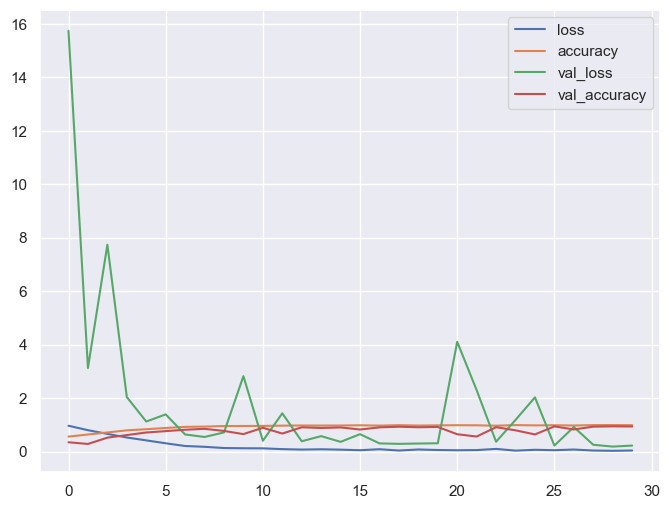

40/40 [==============================] - 12s 304ms/step - loss: 0.2221 - accuracy: 0.9367
Test Loss, Test Accuracy: [0.22212418913841248, 0.936718761920929]


In [38]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# Path to the downloaded weights file
weights_path = '/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/efficientnetb0_notop.h5'

# Ensure the weights file exists
if not tf.io.gfile.exists(weights_path):
    raise FileNotFoundError(f"Weights file not found at {weights_path}")

# Load the dataset - ensure 'training_dataset' and 'testing_dataset' are predefined with preprocessing
# Assuming datasets are loaded and preprocessed correctly to have three channels (RGB)

# Model setup with loaded weights
EffNet = tf.keras.applications.EfficientNetB0(include_top=False, weights=weights_path, input_shape=(224, 224, 3))
EffNet.trainable = True  # Fine-tune all layers

# Correct the input shape handling for grayscale to RGB conversion
inputs = tf.keras.layers.Input(shape=(128, 128, 1), name='input_layer')
x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])  # Duplicate channels to simulate RGB
x = EffNet(x)  # Pass the simulated RGB image through EfficientNet
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
learning_rate = 0.01
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Model summary
model.summary()

# Training the Model
history = model.fit(training_dataset, validation_data=testing_dataset, epochs=30, verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.show()

# Evaluate the performance
results = model.evaluate(testing_dataset)
print(f"Test Loss, Test Accuracy: {results}")

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 16813124 (64.14 MB)
Trainable params: 2098436 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1

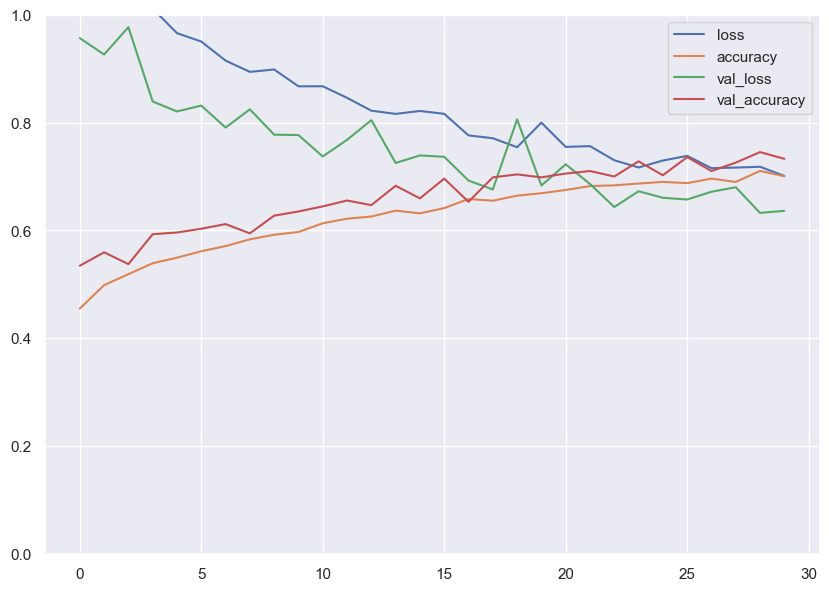

In [39]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the dataset directory path
directory = '/Users/saibalajikondapalli/Documents/Python Practice/Alzheimers-Disease-Prediction-through-Transfer-Learning/Dataset'

# Prepare the datasets
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",  # Change to "rgb" since VGG16 expects three channels input
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False  # Change this if your TensorFlow version does not support it
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",  # Change to "rgb" as above
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False  # Change this if needed
)

# Load the VGG16 network
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model

# Create a new 'top' model to put on top of the base model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Assuming you have 4 classes, use softmax for multi-class classification
])

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class problem
              metrics=['accuracy'])

# Summarize the model structure
model.summary()

# Train the model
history = model.fit(
    training_dataset,
    epochs=30,
    validation_data=testing_dataset
)

# Visualize the training process
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # Set the vertical range to [0-1]
plt.show()